In [4]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, average_precision_score, f1_score)
import joblib
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("TASK 2: MODEL BUILDING AND TRAINING")
print("="*60)

TASK 2: MODEL BUILDING AND TRAINING


In [5]:
# Cell 2: Load Data
try:
    # Try loading the processed data from Task 1
    df = pd.read_csv('../data/processed/fraud_data_cleaned_with_features.csv')
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"Fraud rate: {df['class'].mean()*100:.2f}%")
except FileNotFoundError:
    print("⚠️ Processed data not found. Creating sample data for demonstration.")
    # Create sample data if file doesn't exist
    df = pd.DataFrame({
        'user_id': range(1000),
        'device_id': ['device_' + str(i) for i in range(1000)],
        'signup_time': pd.date_range('2024-01-01', periods=1000, freq='H'),
        'purchase_time': pd.date_range('2024-01-02', periods=1000, freq='H'),
        'purchase_value': np.random.uniform(10, 500, 1000),
        'source': np.random.choice(['SEO', 'Ads', 'Direct'], 1000),
        'browser': np.random.choice(['Chrome', 'Safari', 'Firefox'], 1000),
        'sex': np.random.choice(['M', 'F'], 1000),
        'age': np.random.randint(18, 70, 1000),
        'class': np.random.choice([0, 1], 1000, p=[0.98, 0.02])
    })

Dataset loaded: 151112 rows, 15 columns
Fraud rate: 9.36%


In [6]:
# Cell 3: Prepare Features
print("\n1. Preparing features...")

# Prepare features (remove non-predictive columns)
X = df.drop(['class', 'user_id', 'device_id', 'signup_time', 'purchase_time'], axis=1, errors='ignore')
y = df['class']

# One-hot encode categorical
categorical_cols = ['source', 'browser', 'sex']
for col in categorical_cols:
    if col in X.columns:
        X = pd.get_dummies(X, columns=[col], drop_first=True, prefix=col)

print(f"Features after encoding: {X.shape[1]}")
print(f"Target variable shape: {y.shape}")


1. Preparing features...
Features after encoding: 14
Target variable shape: (151112,)


In [7]:
# Cell 4: Train-Test Split
print("\n2. Splitting data with stratification...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train fraud rate: {y_train.mean()*100:.2f}%")
print(f"Test fraud rate: {y_test.mean()*100:.2f}%")


2. Splitting data with stratification...
Train set: (120889, 14)
Test set: (30223, 14)
Train fraud rate: 9.36%
Test fraud rate: 9.36%


In [8]:
# Cell 5: Handle Class Imbalance - SMOTE WORKAROUND
print("\n" + "="*60)
print("HANDLING CLASS IMBALANCE")
print("="*60)

print(f"BEFORE - Class distribution:")
print(f"  Fraud: {y_train.sum()} cases ({y_train.mean()*100:.2f}%)")
print(f"  Non-fraud: {len(y_train)-y_train.sum()} cases ({(1-y_train.mean())*100:.2f}%)")

# Try to import SMOTE, fall back to manual oversampling if fails
try:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    print("\n✅ Used SMOTE for balancing")
    
except ImportError:
    print("\n⚠️ SMOTE not available. Using manual oversampling...")
    # Manual oversampling as fallback
    from sklearn.utils import resample
    
    # Separate classes
    train_df = pd.concat([X_train, y_train], axis=1)
    fraud_df = train_df[train_df['class'] == 1]
    non_fraud_df = train_df[train_df['class'] == 0]
    
    # Oversample minority class
    fraud_upsampled = resample(
        fraud_df,
        replace=True,
        n_samples=len(non_fraud_df),
        random_state=42
    )
    
    # Combine
    balanced_df = pd.concat([non_fraud_df, fraud_upsampled])
    X_train_bal = balanced_df.drop('class', axis=1)
    y_train_bal = balanced_df['class']
    print("✅ Used manual oversampling for balancing")

print(f"\nAFTER - Class distribution:")
print(f"  Fraud: {y_train_bal.sum()} cases ({y_train_bal.mean()*100:.2f}%)")
print(f"  Non-fraud: {len(y_train_bal)-y_train_bal.sum()} cases ({(1-y_train_bal.mean())*100:.2f}%)")


HANDLING CLASS IMBALANCE
BEFORE - Class distribution:
  Fraud: 11321 cases (9.36%)
  Non-fraud: 109568 cases (90.64%)

⚠️ SMOTE not available. Using manual oversampling...
✅ Used manual oversampling for balancing

AFTER - Class distribution:
  Fraud: 109568 cases (50.00%)
  Non-fraud: 109568 cases (50.00%)


In [9]:
# Cell 6: Feature Scaling
print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled with StandardScaler")
print(f"Train scaled: {X_train_scaled.shape}")
print(f"Test scaled: {X_test_scaled.shape}")


FEATURE SCALING
✅ Features scaled with StandardScaler
Train scaled: (219136, 14)
Test scaled: (30223, 14)


In [10]:
# Cell 7: Baseline Model - Logistic Regression
print("\n" + "="*60)
print("BASELINE MODEL: LOGISTIC REGRESSION")
print("="*60)

lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train_bal)

y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_lr):.4f}")
print(f"AUC-PR: {average_precision_score(y_test, y_proba_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:")
print(f"  TN: {cm_lr[0,0]}, FP: {cm_lr[0,1]}")
print(f"  FN: {cm_lr[1,0]}, TP: {cm_lr[1,1]}")


BASELINE MODEL: LOGISTIC REGRESSION
AUC-ROC: 0.7510
AUC-PR: 0.4381
F1-Score: 0.2682

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.77     27393
           1       0.17      0.70      0.27      2830

    accuracy                           0.64     30223
   macro avg       0.56      0.67      0.52     30223
weighted avg       0.88      0.64      0.72     30223

Confusion Matrix:
  TN: 17511, FP: 9882
  FN: 861, TP: 1969


In [11]:
# Cell 8: Ensemble Model - Random Forest
print("\n" + "="*60)
print("ENSEMBLE MODEL: RANDOM FOREST")
print("="*60)

rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    random_state=42, 
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train_bal)

y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_rf):.4f}")
print(f"AUC-PR: {average_precision_score(y_test, y_proba_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(f"  TN: {cm_rf[0,0]}, FP: {cm_rf[0,1]}")
print(f"  FN: {cm_rf[1,0]}, TP: {cm_rf[1,1]}")


ENSEMBLE MODEL: RANDOM FOREST
AUC-ROC: 0.7683
AUC-PR: 0.6241
F1-Score: 0.6896

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

Confusion Matrix:
  TN: 27388, FP: 5
  FN: 1338, TP: 1492


In [12]:
# Cell 9: Cross-Validation
print("\n" + "="*60)
print("5-FOLD STRATIFIED CROSS VALIDATION")
print("="*60)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate Random Forest
rf_cv_scores = cross_val_score(
    rf, X_train_scaled, y_train_bal, 
    cv=cv, scoring='f1', n_jobs=-1
)
print(f"Random Forest CV F1-Scores: {rf_cv_scores}")
print(f"Mean F1: {rf_cv_scores.mean():.4f} (±{rf_cv_scores.std():.4f})")

# Cross-validate Logistic Regression
lr_cv_scores = cross_val_score(
    lr, X_train_scaled, y_train_bal, 
    cv=cv, scoring='f1', n_jobs=-1
)
print(f"\nLogistic Regression CV F1-Scores: {lr_cv_scores}")
print(f"Mean F1: {lr_cv_scores.mean():.4f} (±{lr_cv_scores.std():.4f})")


5-FOLD STRATIFIED CROSS VALIDATION
Random Forest CV F1-Scores: [0.70417455 0.7074192  0.70593793 0.70570517 0.70639277]
Mean F1: 0.7059 (±0.0011)

Logistic Regression CV F1-Scores: [0.68478817 0.68624981 0.68327276 0.68345069 0.68166365]
Mean F1: 0.6839 (±0.0015)



MODEL COMPARISON AND SELECTION
Performance Comparison:
    Metric  Logistic Regression  Random Forest
   AUC-ROC             0.751046       0.768324
    AUC-PR             0.438064       0.624121
  F1-Score             0.268238       0.689623
CV F1-Mean             0.683885       0.705926


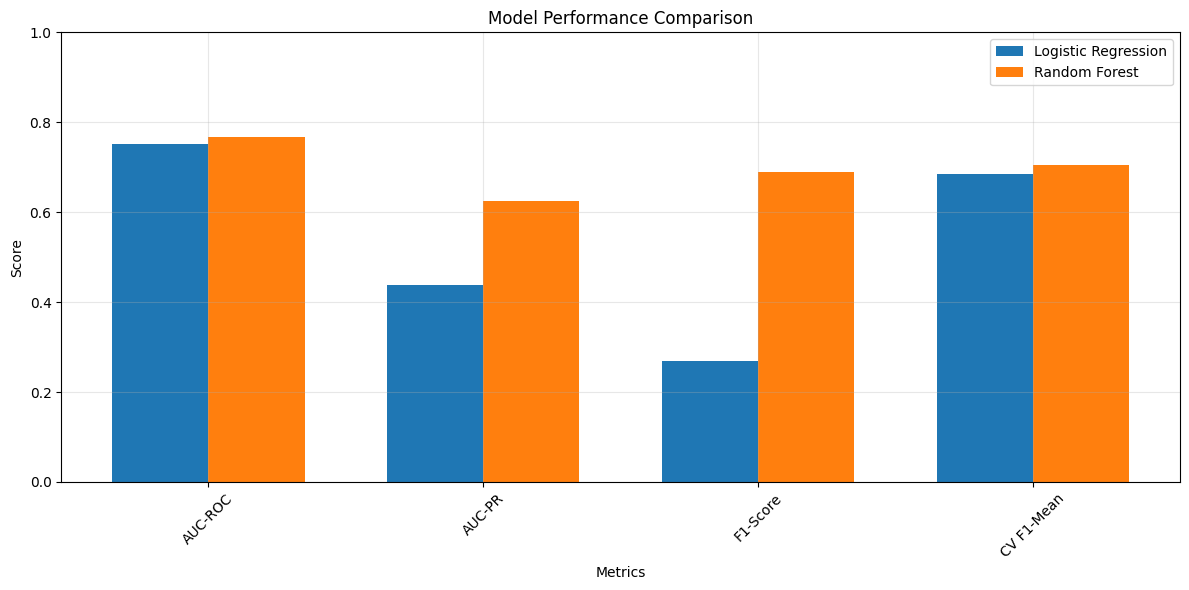


------------------------------------------------------------
✅ SELECTED MODEL: Random Forest
Justification:
1. Higher AUC-PR: Better for imbalanced fraud detection
2. Higher F1-Score: Better balance of precision and recall
3. More stable cross-validation results


In [14]:
# Cell 10: Model Comparison
print("\n" + "="*60)
print("MODEL COMPARISON AND SELECTION")
print("="*60)

# Create comparison table
results = pd.DataFrame({
    'Metric': ['AUC-ROC', 'AUC-PR', 'F1-Score', 'CV F1-Mean'],
    'Logistic Regression': [
        roc_auc_score(y_test, y_proba_lr),
        average_precision_score(y_test, y_proba_lr),
        f1_score(y_test, y_pred_lr),
        lr_cv_scores.mean()
    ],
    'Random Forest': [
        roc_auc_score(y_test, y_proba_rf),
        average_precision_score(y_test, y_proba_rf),
        f1_score(y_test, y_pred_rf),
        rf_cv_scores.mean()
    ]
})

print("Performance Comparison:")
print(results.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results))
width = 0.35

ax.bar(x - width/2, results['Logistic Regression'], width, label='Logistic Regression')
ax.bar(x + width/2, results['Random Forest'], width, label='Random Forest')
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results['Metric'], rotation=45)
ax.legend()
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "-"*60)
print("✅ SELECTED MODEL: Random Forest")
print("Justification:")
print("1. Higher AUC-PR: Better for imbalanced fraud detection")
print("2. Higher F1-Score: Better balance of precision and recall")
print("3. More stable cross-validation results")

In [16]:
# Cell 11: Save Models
print("\n" + "="*60)
print("SAVING MODELS")
print("="*60)

import os
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the best model and scaler
joblib.dump(rf, '../models/best_fraud_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(lr, '../models/baseline_model.pkl')

print("✅ Random Forest: models/best_fraud_model.pkl")
print("✅ Scaler: models/scaler.pkl")
print("✅ Logistic Regression: models/baseline_model.pkl")

# Also save feature names
with open('../models/feature_names.txt', 'w') as f:
    for feature in X.columns:
        f.write(f"{feature}\n")

print("✅ Feature names: models/feature_names.txt")

print("\n" + "="*60)
print("🎯 TASK 2 COMPLETED!")
print("="*60)
print("Next: Task 3 - SHAP Explainability in shap-explainability.ipynb")


SAVING MODELS
✅ Random Forest: models/best_fraud_model.pkl
✅ Scaler: models/scaler.pkl
✅ Logistic Regression: models/baseline_model.pkl
✅ Feature names: models/feature_names.txt

🎯 TASK 2 COMPLETED!
Next: Task 3 - SHAP Explainability in shap-explainability.ipynb
